# **3way**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 3.5 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 89.8MB/s]


Initial Evaluation:
Ground Truth / Predicted
1 / 0
1 / 1
1 / 0
1 / 0
1 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
2 / 2
2 / 1
2 / 2
2 / 2


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Model tested on 100 tasks. Accuracy: 55.20%
Confusion Matrix:
[[5 0 0]
 [4 1 0]
 [0 2 3]]
Precision: 0.6296
Recall: 0.6000
F1 Score: 0.5714
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.56      1.00      0.71         5
bacterial_panicle_blight       0.33      0.20      0.25         5
                    smut       1.00      0.60      0.75         5

                accuracy                           0.60        15
               macro avg       0.63      0.60      0.57        15
            weighted avg       0.63      0.60      0.57        15



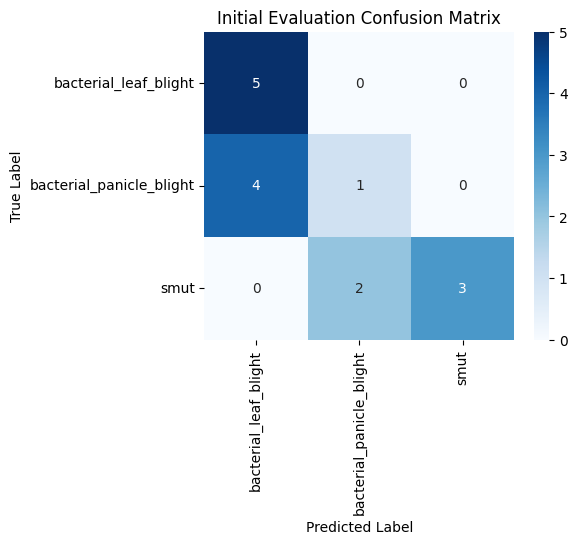

100%|██████████| 100/100 [01:06<00:00,  1.51it/s, loss=1.01]

Post-Training Evaluation:



100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

Model tested on 100 tasks. Accuracy: 59.80%


In [ ]:
!pip install easyfsl scikit-learn matplotlib seaborn
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vit_b_16
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/rice_leaf_diseases-3way/train'
test_data_path = '/content/drive/MyDrive/rice_leaf_diseases-3way/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = vit_b_16(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()


# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# Calculate metrics for the post-training evaluation
# conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
# precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
# recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
# f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
# class_report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)

# print(f"Confusion Matrix:\n{conf_matrix}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Classification Report:\n{class_report}")

# Plot confusion matrix for post-training evaluation
# plt.figure(figsize=(5, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title("Post-Training Evaluation Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
0 / 0
0 / 0
0 / 0
0 / 0
0 / 1
1 / 1
1 / 0
1 / 1
1 / 1
1 / 1


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Model tested on 100 tasks. Accuracy: 73.80%
Confusion Matrix:
[[4 1 0]
 [1 4 0]
 [0 0 5]]
Precision: 0.8667
Recall: 0.8667
F1 Score: 0.8667
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.80      0.80      0.80         5
bacterial_panicle_blight       0.80      0.80      0.80         5
                    smut       1.00      1.00      1.00         5

                accuracy                           0.87        15
               macro avg       0.87      0.87      0.87        15
            weighted avg       0.87      0.87      0.87        15



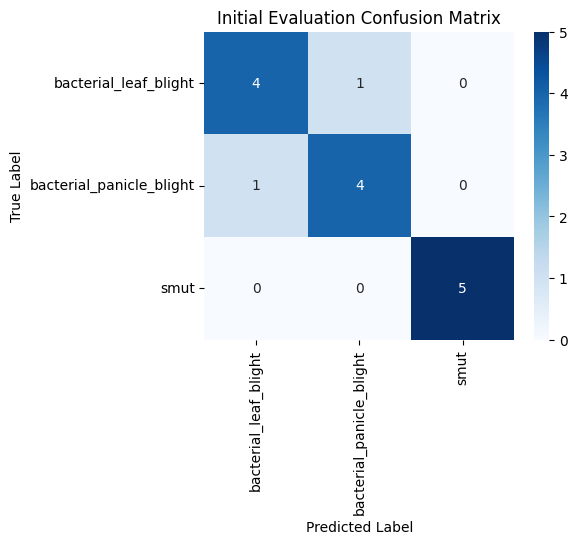

100%|██████████| 100/100 [01:50<00:00,  1.11s/it, loss=1.01]

Post-Training Evaluation:



100%|██████████| 100/100 [00:43<00:00,  2.32it/s]

Model tested on 100 tasks. Accuracy: 66.20%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
0 / 0
0 / 1
0 / 0
0 / 0
0 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 1
2 / 1
2 / 2
2 / 2


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Model tested on 100 tasks. Accuracy: 68.87%
Confusion Matrix:
[[3 2 0]
 [0 5 0]
 [0 2 3]]
Precision: 0.8519
Recall: 0.7333
F1 Score: 0.7381
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       1.00      0.60      0.75         5
bacterial_panicle_blight       0.56      1.00      0.71         5
                    smut       1.00      0.60      0.75         5

                accuracy                           0.73        15
               macro avg       0.85      0.73      0.74        15
            weighted avg       0.85      0.73      0.74        15



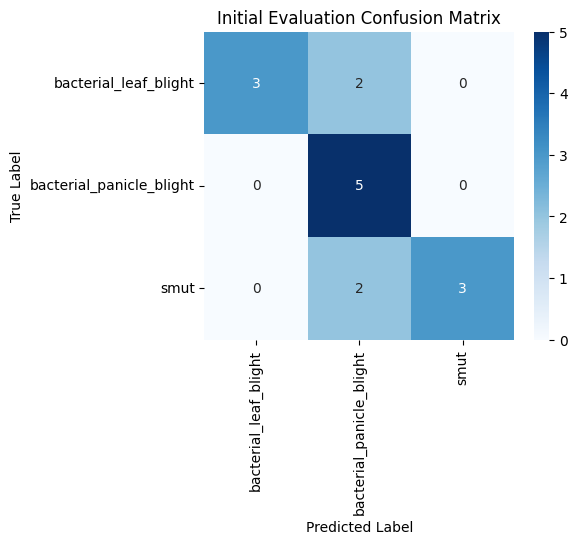

100%|██████████| 100/100 [02:42<00:00,  1.62s/it, loss=0.899]

Post-Training Evaluation:



100%|██████████| 100/100 [01:05<00:00,  1.54it/s]

Model tested on 100 tasks. Accuracy: 72.13%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **5Way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
4 / 2
4 / 4
4 / 4
4 / 4
4 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
3 / 1
3 / 2
3 / 3
3 / 2
3 / 3
1 / 2
1 / 2
1 / 1
1 / 1
1 / 2
0 / 2
0 / 2
0 / 2
0 / 2
0 / 0


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Model tested on 100 tasks. Accuracy: 42.08%
Confusion Matrix:
[[1 0 4 0 0]
 [0 2 3 0 0]
 [0 0 5 0 0]
 [0 1 2 2 0]
 [0 0 2 0 3]]
Precision: 0.7958
Recall: 0.5200
F1 Score: 0.5262
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       1.00      0.20      0.33         5
bacterial_panicle_blight       0.67      0.40      0.50         5
                  normal       0.31      1.00      0.48         5
      rice_sheath_blight       1.00      0.40      0.57         5
                    smut       1.00      0.60      0.75         5

                accuracy                           0.52        25
               macro avg       0.80      0.52      0.53        25
            weighted avg       0.80      0.52      0.53        25



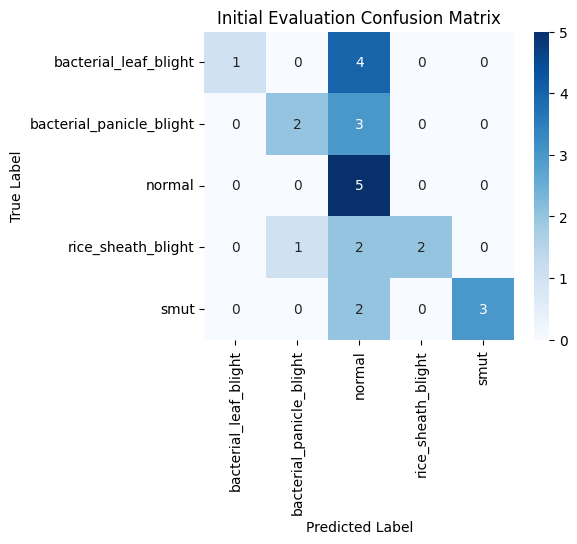

100%|██████████| 100/100 [01:40<00:00,  1.00s/it, loss=1.49]

Post-Training Evaluation:



100%|██████████| 100/100 [00:42<00:00,  2.35it/s]

Model tested on 100 tasks. Accuracy: 53.28%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/rice_leaf_diseases-5way/train'
test_data_path = '/content/drive/MyDrive/rice_leaf_diseases-5way/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = vit_b_16(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
1 / 3
1 / 1
1 / 1
1 / 1
1 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
0 / 3
0 / 0
0 / 2
0 / 1
0 / 0
4 / 1
4 / 4
4 / 1
4 / 4
4 / 4
2 / 2
2 / 1
2 / 2
2 / 3
2 / 2


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Model tested on 100 tasks. Accuracy: 68.68%
Confusion Matrix:
[[2 1 1 1 0]
 [1 3 0 1 0]
 [0 1 3 1 0]
 [0 0 0 5 0]
 [0 2 0 0 3]]
Precision: 0.6940
Recall: 0.6400
F1 Score: 0.6372
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.67      0.40      0.50         5
bacterial_panicle_blight       0.43      0.60      0.50         5
                  normal       0.75      0.60      0.67         5
      rice_sheath_blight       0.62      1.00      0.77         5
                    smut       1.00      0.60      0.75         5

                accuracy                           0.64        25
               macro avg       0.69      0.64      0.64        25
            weighted avg       0.69      0.64      0.64        25



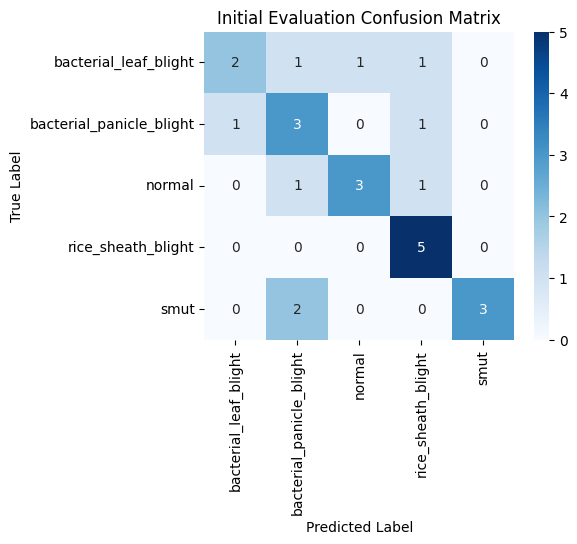

100%|██████████| 100/100 [02:49<00:00,  1.70s/it, loss=1.55]

Post-Training Evaluation:



100%|██████████| 100/100 [01:07<00:00,  1.48it/s]

Model tested on 100 tasks. Accuracy: 58.52%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
1 / 4
1 / 1
1 / 1
1 / 2
1 / 1
3 / 3
3 / 4
3 / 4
3 / 3
3 / 3
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
4 / 0
4 / 4
4 / 4
4 / 4
4 / 4


100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


Model tested on 100 tasks. Accuracy: 63.00%
Confusion Matrix:
[[5 0 0 0 0]
 [0 3 1 0 1]
 [0 0 5 0 0]
 [0 0 0 3 2]
 [1 0 0 0 4]]
Precision: 0.8476
Recall: 0.8000
F1 Score: 0.7970
Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.83      1.00      0.91         5
bacterial_panicle_blight       1.00      0.60      0.75         5
                  normal       0.83      1.00      0.91         5
      rice_sheath_blight       1.00      0.60      0.75         5
                    smut       0.57      0.80      0.67         5

                accuracy                           0.80        25
               macro avg       0.85      0.80      0.80        25
            weighted avg       0.85      0.80      0.80        25



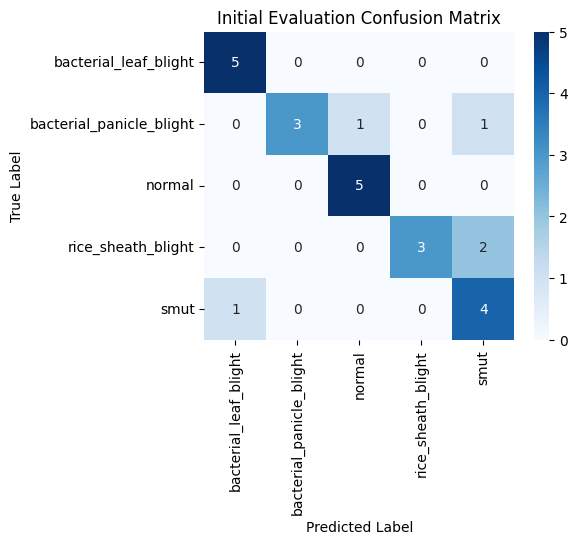

100%|██████████| 100/100 [04:19<00:00,  2.60s/it, loss=1.3]

Post-Training Evaluation:



100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

Model tested on 100 tasks. Accuracy: 73.52%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **10way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
0 / 9
0 / 3
0 / 0
0 / 0
0 / 9
8 / 8
8 / 5
8 / 3
8 / 3
8 / 3
1 / 2
1 / 3
1 / 7
1 / 3
1 / 0
5 / 3
5 / 3
5 / 3
5 / 3
5 / 5
7 / 2
7 / 7
7 / 7
7 / 9
7 / 9
6 / 9
6 / 3
6 / 3
6 / 3
6 / 3
3 / 9
3 / 9
3 / 3
3 / 2
3 / 5
4 / 4
4 / 4
4 / 4
4 / 4
4 / 3
9 / 2
9 / 5
9 / 5
9 / 9
9 / 2
2 / 3
2 / 2
2 / 2
2 / 0
2 / 5


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Model tested on 100 tasks. Accuracy: 25.24%
Confusion Matrix:
[[2 0 0 1 0 0 0 0 0 2]
 [1 0 1 2 0 0 0 1 0 0]
 [1 0 2 1 0 1 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 2]
 [0 0 0 1 4 0 0 0 0 0]
 [0 0 0 4 0 1 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 2 0 2]
 [0 0 0 3 0 1 0 0 1 0]
 [0 0 2 0 0 2 0 0 0 1]]
Precision: 0.3803
Recall: 0.2800
F1 Score: 0.2927
Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.50      0.40      0.44         5
bacterial_leaf_streak       0.00      0.00      0.00         5
           brown_spot       0.29      0.40      0.33         5
           dead_heart       0.06      0.20      0.09         5
         downy_mildew       1.00      0.80      0.89         5
                hispa       0.17      0.20      0.18         5
               normal       0.00      0.00      0.00         5
   rice_sheath_blight       0.67      0.40      0.50         5
                 smut       1.00      0.20      0.33         5
   

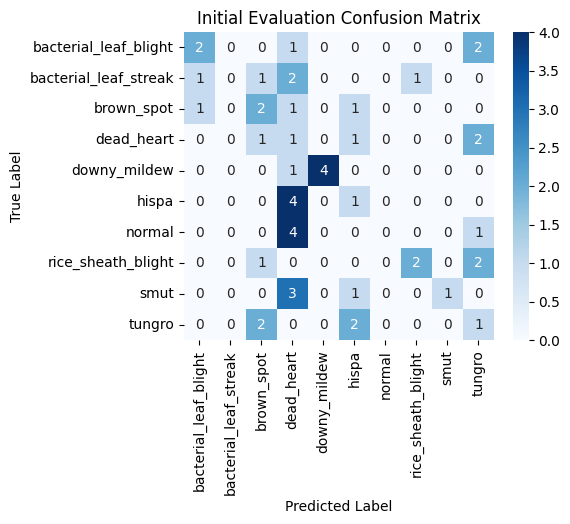

100%|██████████| 100/100 [03:31<00:00,  2.12s/it, loss=1.95]

Post-Training Evaluation:



100%|██████████| 100/100 [01:22<00:00,  1.21it/s]

Model tested on 100 tasks. Accuracy: 41.76%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/rice_leaf_diseases-10way/train'
test_data_path = '/content/drive/MyDrive/rice_leaf_diseases-10way/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = vit_b_16(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

In [ ]:
!pip install easyfsl
#scikit-learn matplotlib seaborn
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vit_b_16
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/rice_leaf_diseases-10way/train'
test_data_path = '/content/drive/MyDrive/rice_leaf_diseases-10way/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = vit_b_16(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()
















# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
# plt.figure(figsize=(5, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title("Initial Evaluation Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 4.7 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 175MB/s]


Initial Evaluation:
Ground Truth / Predicted
6 / 3
6 / 5
6 / 5
6 / 5
6 / 6
5 / 5
5 / 5
5 / 5
5 / 3
5 / 5
9 / 3
9 / 0
9 / 4
9 / 5
9 / 9
8 / 3
8 / 8
8 / 5
8 / 8
8 / 8
7 / 3
7 / 3
7 / 7
7 / 7
7 / 3
3 / 3
3 / 5
3 / 3
3 / 5
3 / 6
2 / 4
2 / 5
2 / 2
2 / 4
2 / 3
0 / 0
0 / 0
0 / 0
0 / 7
0 / 6
1 / 5
1 / 9
1 / 5
1 / 9
1 / 5
4 / 6
4 / 4
4 / 4
4 / 4
4 / 4


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Model tested on 100 tasks. Accuracy: 37.96%
Confusion Matrix:
[[3 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 3 0 0 0 2]
 [0 0 1 1 2 1 0 0 0 0]
 [0 0 0 2 0 2 1 0 0 0]
 [0 0 0 0 4 0 1 0 0 0]
 [0 0 0 1 0 4 0 0 0 0]
 [0 0 0 1 0 3 1 0 0 0]
 [0 0 0 3 0 0 0 2 0 0]
 [0 0 0 1 0 1 0 0 3 0]
 [1 0 0 1 1 1 0 0 0 1]]
Precision: 0.5038
Recall: 0.4200
F1 Score: 0.4056
Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.75      0.60      0.67         5
bacterial_leaf_streak       0.00      0.00      0.00         5
           brown_spot       1.00      0.20      0.33         5
           dead_heart       0.20      0.40      0.27         5
         downy_mildew       0.57      0.80      0.67         5
                hispa       0.27      0.80      0.40         5
               normal       0.25      0.20      0.22         5
   rice_sheath_blight       0.67      0.40      0.50         5
                 smut       1.00      0.60      0.75         5
   

100%|██████████| 100/100 [05:26<00:00,  3.26s/it, loss=1.6]

Post-Training Evaluation:



100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Model tested on 100 tasks. Accuracy: 63.94%
